In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns       
from scipy import stats

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline  
# 为了在jupyter notebook里作图，需要用到这个命令

## Load train data and test data
#### 並先刪除不必要的欄位

In [2]:
train = pd.read_csv("train.csv")
#train.drop("ID", axis = 1, inplace = True)
print (train.shape)
# 取出train data的y值
y_train=train['class']
print ("y_train:",y_train.shape)
train.drop(["ID","class"], axis = 1, inplace = True)
x_train=train
print ("x_train:",x_train.shape)


(7160, 184)
y_train: (7160,)
x_train: (7160, 182)


In [3]:
x_test = pd.read_csv("test.csv")
x_test_id=x_test["id"]
x_test.drop(["id"], axis = 1, inplace = True)
print ("x_test:",x_test.shape)
print (train.info())

x_test: (1791, 182)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Columns: 182 entries, appearedTimeOfDay to cooc_151
dtypes: bool(168), float64(6), int64(3), object(5)
memory usage: 1.9+ MB
None


## 將train data和test data combine起來，後續一起做資料處理
#### 如果分開做的話，做one-hot-encoding時可能會有feature數量不一致的問題

In [4]:
data=pd.concat([x_train,x_test],axis=0,ignore_index = False)
print (data.shape)
#紀錄train data的筆數,後續EDA完成後要再依此筆數拆分train data和test data
x_train_qty=x_train.shape[0]

(8951, 182)


## 判斷fetures是屬於categorical or numerical

In [5]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = data.select_dtypes(include=['object']).columns
print(categorical_features)
numerical_features = data.select_dtypes(exclude = ["object"]).columns
print(numerical_features)
print("Categorical features : " + str(len(categorical_features)))
print("Numerical features : " + str(len(numerical_features)))

Index(['appearedTimeOfDay', 'city', 'continent', 'weather', 'weatherIcon'], dtype='object')
Index(['appearedHour', 'appearedMinute', 'terrainType', 'closeToWater',
       'temperature', 'windSpeed', 'pressure', 'population_density', 'urban',
       'suburban',
       ...
       'cooc_142', 'cooc_143', 'cooc_144', 'cooc_145', 'cooc_146', 'cooc_147',
       'cooc_148', 'cooc_149', 'cooc_150', 'cooc_151'],
      dtype='object', length=177)
Categorical features : 5
Numerical features : 177


## 檢查Features datatype

In [6]:
print(data.dtypes.unique())
print(len(data.select_dtypes(include=['O']).columns))
print(data.select_dtypes(include=['O']).columns)

[dtype('O') dtype('int64') dtype('bool') dtype('float64')]
5
Index(['appearedTimeOfDay', 'city', 'continent', 'weather', 'weatherIcon'], dtype='object')


In [7]:
data.head()

,appearedTimeOfDay,appearedHour,appearedMinute,terrainType,closeToWater,city,continent,weather,temperature,windSpeed,...,cooc_142,cooc_143,cooc_144,cooc_145,cooc_146,cooc_147,cooc_148,cooc_149,cooc_150,cooc_151
0,evening,19,10,13,False,Bangkok,Asia,Clear,27.8,9.00,...,False,False,False,False,False,False,False,False,False,False
1,night,5,19,13,True,New_York,America,Clear,26.1,8.70,...,False,False,False,False,False,False,False,False,False,False
2,evening,19,46,0,True,New_York,America,Clear,24.7,16.82,...,False,False,False,False,False,False,False,False,False,False
3,morning,11,10,0,True,Hobart,Australia,Clear,12.7,13.25,...,False,False,False,False,False,False,False,False,False,False
4,evening,18,32,13,True,Los_Angeles,America,PartlyCloudy,19.1,5.78,...,False,False,False,False,False,False,False,False,False,False


In [8]:
data.describe()

,appearedHour,appearedMinute,terrainType,temperature,windSpeed,pressure,population_density,gymDistanceKm,pokestopDistanceKm
count,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000
mean,10.654452,30.643168,9.720590,23.281008,7.510169,1014.904328,1541.905140,2.987937,0.562947
std,7.152858,17.439499,4.941831,6.054764,4.617323,5.828866,2230.860698,46.908371,7.479374
min,0.000000,0.000000,0.000000,4.800000,0.000000,996.330000,0.000000,0.004516,0.000319
25%,4.000000,16.000000,7.000000,18.500000,3.920000,1010.695000,69.585650,0.178437,0.050817
50%,10.000000,32.000000,13.000000,23.800000,6.630000,1015.290000,635.549800,0.314365,0.132209
75%,17.000000,46.000000,13.000000,27.500000,10.010000,1019.290000,1955.863600,0.577406,0.310317
max,23.000000,59.000000,16.000000,41.200000,56.130000,1034.170000,10000.000000,3859.424664,455.313099


## 處理時間欄位

In [9]:
data['appearedtime'] = data['appearedHour']+(data['appearedMinute']/60)
#maxtime=data['appearedtime'].max()
maxtime=24
data['appearedtime'].head()

0    19.166667
1     5.316667
2    19.766667
3    11.166667
4    18.533333
Name: appearedtime, dtype: float64

In [10]:
data['appearedtime_sin'] = np.sin(2 * np.pi * data['appearedtime']/maxtime)
data['appearedtime_cos'] = np.cos(2 * np.pi * data['appearedtime']/maxtime)

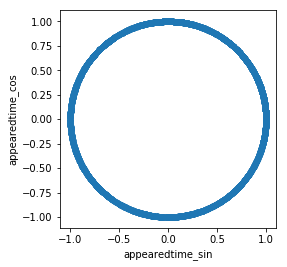

In [11]:
ax = data.plot.scatter('appearedtime_sin', 'appearedtime_cos').set_aspect('equal')

## 刪除不需要的features

In [12]:
# city已經可以區分地區,所以不需要continent
data = data.drop(['continent'], axis=1)
#與weather類似，所以移除weatherIcon
data = data.drop(['weatherIcon'], axis=1)
#data = data.drop(['weather'], axis=1)
data = data.drop(['appearedHour', 'appearedMinute','appearedtime'], axis=1)
# 時間欄位與appearedTimeOfDay效果相似,保留appearedTimeOfDay
#data = data.drop(['appearedTimeOfDay'], axis=1)
data = data.drop(['appearedtime_sin', 'appearedtime_cos'], axis=1)


## 顯示數值欄位基本資訊

In [13]:
data.describe()

,terrainType,temperature,windSpeed,pressure,population_density,gymDistanceKm,pokestopDistanceKm
count,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000
mean,9.720590,23.281008,7.510169,1014.904328,1541.905140,2.987937,0.562947
std,4.941831,6.054764,4.617323,5.828866,2230.860698,46.908371,7.479374
min,0.000000,4.800000,0.000000,996.330000,0.000000,0.004516,0.000319
25%,7.000000,18.500000,3.920000,1010.695000,69.585650,0.178437,0.050817
50%,13.000000,23.800000,6.630000,1015.290000,635.549800,0.314365,0.132209
75%,13.000000,27.500000,10.010000,1019.290000,1955.863600,0.577406,0.310317
max,16.000000,41.200000,56.130000,1034.170000,10000.000000,3859.424664,455.313099


## 判斷是否有missing data

In [14]:
# Missing data in train
data_na = data.isnull().sum()
data_na = data_na[data_na>0]
data_na.sort_values(ascending=False)

Series([], dtype: int64)

## 查看min為0的筆數是否異常

In [15]:
print (data.loc[(data['population_density']==0),'population_density'].count())
data.loc[(data['population_density']==0),'population_density'].count()/data.shape[0]

1652


0.18456038431460173

## 將數值為不應該為0的值改用平均值

In [16]:
# 使用該city的population_density平均值取代0值
for i in data['city'].unique():
    mean=data[data['city']==i].loc[:,'population_density'].mean()
    data.loc[(data['city']==i) & (data['population_density']==0),'population_density']=mean

In [17]:
data.head()

,appearedTimeOfDay,terrainType,closeToWater,city,weather,temperature,windSpeed,pressure,population_density,urban,...,cooc_142,cooc_143,cooc_144,cooc_145,cooc_146,cooc_147,cooc_148,cooc_149,cooc_150,cooc_151
0,evening,13,False,Bangkok,Clear,27.8,9.00,1008.96,6019.04440,True,...,False,False,False,False,False,False,False,False,False,False
1,night,13,True,New_York,Clear,26.1,8.70,1018.96,1172.14576,False,...,False,False,False,False,False,False,False,False,False,False
2,evening,0,True,New_York,Clear,24.7,16.82,1023.22,1172.14576,False,...,False,False,False,False,False,False,False,False,False,False
3,morning,0,True,Hobart,Clear,12.7,13.25,1014.19,128.89505,False,...,False,False,False,False,False,False,False,False,False,False
4,evening,13,True,Los_Angeles,PartlyCloudy,19.1,5.78,1011.36,4188.39100,True,...,False,False,False,False,False,False,False,False,False,False


In [18]:
data.describe()

,terrainType,temperature,windSpeed,pressure,population_density,gymDistanceKm,pokestopDistanceKm
count,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000
mean,9.720590,23.281008,7.510169,1014.904328,1786.441753,2.987937,0.562947
std,4.941831,6.054764,4.617323,5.828866,2143.401196,46.908371,7.479374
min,0.000000,4.800000,0.000000,996.330000,0.000000,0.004516,0.000319
25%,7.000000,18.500000,3.920000,1010.695000,458.582340,0.178437,0.050817
50%,13.000000,23.800000,6.630000,1015.290000,1135.319600,0.314365,0.132209
75%,13.000000,27.500000,10.010000,1019.290000,2261.157000,0.577406,0.310317
max,16.000000,41.200000,56.130000,1034.170000,10000.000000,3859.424664,455.313099


## 將以數值做分類型態的feature的資料型態轉換成字串，避免訓練時被當作數值處理
#### 例terrainType是以0,1,2..來表示不同種類的地形，但並非數值，所以要做轉換

In [19]:
#data.terrainType = data.terrainType.astype( str )
features_to_str=["terrainType"]
data[features_to_str]=data[features_to_str].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8951 entries, 0 to 1790
Columns: 178 entries, appearedTimeOfDay to cooc_151
dtypes: bool(168), float64(6), object(4)
memory usage: 2.2+ MB


## 對數值欄位做 normalization

In [20]:
from sklearn import preprocessing
# 前面已經取過一次numerical_features,但因為中間features有增減，所以再取一次
numerical_features = data.select_dtypes(exclude = ["object"]).columns
data[numerical_features] = preprocessing.scale(data[numerical_features])
print (data.head())

  appearedTimeOfDay terrainType  closeToWater         city       weather  \
0           evening          13     -0.901079      Bangkok         Clear   
1             night          13      1.109781     New_York         Clear   
2           evening           0      1.109781     New_York         Clear   
3           morning           0      1.109781       Hobart         Clear   
4           evening          13      1.109781  Los_Angeles  PartlyCloudy   

   temperature  windSpeed  pressure  population_density     urban    ...     \
0     0.746395   0.322679 -1.019866            1.974824  1.133395    ...      
1     0.465609   0.257703  0.695830           -0.286615 -0.882305    ...      
2     0.234373   2.016396  1.426716           -0.286615 -0.882305    ...      
3    -1.747648   1.243178 -0.122557           -0.773369 -0.882305    ...      
4    -0.690571  -0.374733 -0.608099            1.120688  1.133395    ...      

   cooc_142  cooc_143  cooc_144  cooc_145  cooc_146  cooc_147  cooc_

## 對類別型features做one-hot-encoding
#### 某一類別型feature有三個值，則會被轉換成三個features

In [21]:
data=pd.get_dummies(data)
data.shape

(8951, 292)

In [22]:
feture_qty=data.shape[1]
print (feture_qty)

292


## 將整理後的資料再拆成train data和test data

In [23]:
x_train=data[:x_train_qty]
x_test=data[x_train_qty:]
print (x_train.shape)
print (x_test.shape)

(7160, 292)
(1791, 292)


## 對train data y 做 one-hot-encoding

In [24]:
# one hot encoding

y_one_hot = np.zeros((len(y_train), 6))  
y_one_hot[np.arange(len(y_train)), y_train] = 1

print (y_one_hot.shape)


(7160, 6)


## 設定訓練結果存放路徑

In [41]:
import os
model_path = os.path.join(os.getcwd(), 'saved_models')
#model_name = 'keras_adam_trained_model.h5'
if not os.path.isdir(model_path):
    os.makedirs(model_path)
#model_path_name = os.path.join(model_path, model_name)

# 用 keras 建 model

## import keras library

In [42]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint,EarlyStopping

## 模型訓練參數設定

In [43]:
# model add parameter
model_dropout=0.4
# model fit parameter
#batch_size = 128 #原本32放大有幫助
#batch_size_list=[32,64,128] # 64驗證較佳
batch_size_list=[32,64,96,128,160]
epochs = 300 #batch_size調大,epochs也要調大
learning_rate = 0.001 #預設即為0.001。這case調大後效果不佳，調小效果也不明顯，所以使用預設值即可 
train_data_ratio = 0.85 # 調整稍有變化

# check point parameter
cp_monitor='val_acc'

# early stop parameter
es_monitor='val_acc'
es_patience=80


In [56]:
def train_model(batch_size_in,verbose_in=1):
    #check point
    model_name = 'adam_' + str(batch_size_in)
    model_path_name = os.path.join(model_path, model_name)
    checkpoint = ModelCheckpoint(model_path_name, monitor=cp_monitor, 
                             verbose=2, save_best_only=True, save_weights_only=False)
    #early stop
    earlystop = EarlyStopping(monitor=es_monitor, patience=es_patience, verbose=1)    
    #使用dropout無太大變化
    #使用2個隱藏層沒太大變化
    model = keras.Sequential()
    model.add(Dropout(model_dropout, input_shape=(feture_qty,)))
    model.add(Dense(200,activation='relu'))
    #model.add(Dense(128, activation='relu', input_shape=(feture_qty,)))
    model.add(Dropout(model_dropout))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(model_dropout))
    model.add(Dense(50, activation='relu')) #多這一層沒幫助
    model.add(Dropout(model_dropout))
    model.add(Dense(6, activation='softmax')) 

  #  print(model.summary())
    
    opt=keras.optimizers.Adam(lr=learning_rate)
    #opt=keras.optimizers.SGD() #相同條件下，SGD valid accuracy 0.54562，相較Adam 0.60987差很多
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    #此case加上"shuffle=False"效果比較好一點?
    model_history = model.fit(x=x_train, y=y_one_hot,
                          batch_size=batch_size_in,
                          epochs=epochs,
                          shuffle=False,
                          verbose=verbose_in,
                          validation_split=1 - train_data_ratio, callbacks=[checkpoint,earlystop])
    train_loss = model_history.history['loss']
    train_acc = model_history.history['acc']
    valid_loss = model_history.history['val_loss']
    valid_acc = model_history.history['val_acc']
   # valid_acc_max = model_history.history['val_acc']

    #print ("valid_acc_best",valid_acc_best)

    del model
    return train_loss,train_acc,valid_loss,valid_acc
    #return valid_acc

## Create model

In [55]:
best_valid_acc=0
best_batch_size=0
for batch_size in batch_size_list:
    _,_,_,valid_acc=train_model(batch_size_in=batch_size,verbose_in=0)
    valid_acc_max=np.array(valid_acc).max()
    if valid_acc_max > best_valid_acc :
        best_valid_acc=valid_acc_max
        best_batch_size=batch_size



Epoch 00001: val_acc improved from -inf to 0.35847, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/saved_models/adam_32

Epoch 00002: val_acc improved from 0.35847 to 0.47114, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/saved_models/adam_32

Epoch 00003: val_acc improved from 0.47114 to 0.49814, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/saved_models/adam_32

Epoch 00004: val_acc improved from 0.49814 to 0.51397, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/saved_models/adam_32

Epoch 00005: val_acc improved from 0.51397 to 0.52980, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/saved_models/adam_32

Epoch 00006: val_acc improved from 0.52980 to 0.53631, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/saved_models/adam_32

Epoch 00007: val_acc did not improve from 0.53631

Epoch 00008: val_acc did not improve from 0.53631

Epoch 00009: val_acc did not improve from 0.53631

Epoch 00010: val_acc improved from 0.53631 to

In [48]:
print (best_batch_size)
print (best_valid_acc)
best_model_path_name = os.path.join(model_path, 'adam_' + str(best_batch_size))
print (best_model_path_name)

128
0.6154562376952926
/home/jovyan/mypython/Kaggle/AIA Pokemon/saved_models/adam_128


In [59]:
best_batch_size=256
train_loss,train_acc,valid_loss,valid_acc=train_model(batch_size_in=best_batch_size,verbose_in=1)

Train on 6086 samples, validate on 1074 samples
Epoch 1/300
 - 2s - loss: 1.9650 - acc: 0.1931 - val_loss: 1.7345 - val_acc: 0.2933

Epoch 00001: val_acc improved from -inf to 0.29330, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/saved_models/adam_256
Epoch 2/300
 - 0s - loss: 1.7819 - acc: 0.2545 - val_loss: 1.6997 - val_acc: 0.3585

Epoch 00002: val_acc improved from 0.29330 to 0.35847, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/saved_models/adam_256
Epoch 3/300
 - 0s - loss: 1.7199 - acc: 0.2902 - val_loss: 1.6361 - val_acc: 0.4013

Epoch 00003: val_acc improved from 0.35847 to 0.40130, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/saved_models/adam_256
Epoch 4/300
 - 0s - loss: 1.6666 - acc: 0.3148 - val_loss: 1.5557 - val_acc: 0.4367

Epoch 00004: val_acc improved from 0.40130 to 0.43669, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/saved_models/adam_256
Epoch 5/300
 - 0s - loss: 1.6172 - acc: 0.3451 - val_loss: 1.4824 - val_acc: 0.

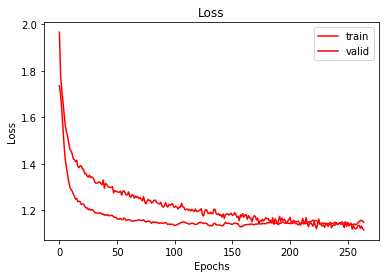

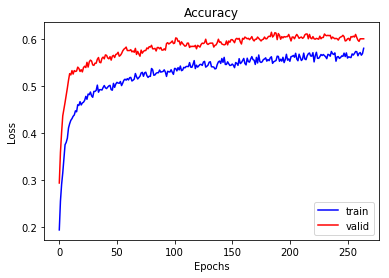

In [60]:
plt.plot(train_loss, 'b', label='train')
plt.plot(valid_loss, 'r', label='valid')
plt.legend()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.plot(train_acc, 'b', label='train')
plt.plot(valid_acc, 'r', label='valid')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()


train_loss = model_history.history['loss']
train_acc = model_history.history['acc']
valid_loss = model_history.history['val_loss']
valid_acc = model_history.history['val_acc']

plt.plot(train_loss, 'b', label='train')
plt.plot(valid_loss, 'r', label='valid')
plt.legend()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.plot(train_acc, 'b', label='train')
plt.plot(valid_acc, 'r', label='valid')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

In [ ]:
# save model，存最後的結果。
# 此case是用checkpoint存最佳的valid accuracy結果，所以將此mark掉
#model.save('my_model.h5')

## 取訓練時最佳的結果來做test預測

In [61]:
# load model
another_model = load_model(best_model_path_name)

In [62]:
y_test_pred = model.predict_classes(x_test)

NameError: name 'model' is not defined

In [ ]:
## 將預測結果與ID做combine
prediction = pd.DataFrame(y_test_pred, columns=['class'])
result = pd.concat([x_test_id, prediction], axis=1)
result.head()

In [ ]:
#儲存結果
result.to_csv('submission_dl.csv', index=False)